# Polars groupby on parquet data 2021+, eager vs lazy

In [1]:
import pandas as pd
import polars as pl
from humanfriendly import format_size, format_number
from simpler_mpl import set_commas, set_common_mpl_styles
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

%load_ext autoreload
%autoreload 2

display(f"Pandas {pd.__version__}, Polars {pl.__version__}")

from cell_profiler import cell_profiler as cp
%start_cell_profiler

def show_rows_memory(df, deep=False):
    """
    Show rows and memory cost of a Pandas/Polars dataframe
    `deep=True` only has an impact on Pandas numpy-backed string columns, which otherwise are undercounted
    """
    num_bytes = 0
    df_type = 'Unknown'
    try:
        num_bytes = df.estimated_size() # try Polars
        df_type = 'Polars'
    except AttributeError:
        pass
    try:
        num_bytes = df.memory_usage(deep=deep, index=False).sum() # try Pandas
        df_type = 'Pandas'
    except AttributeError:
        pass
    display(f"{df_type} df with {format_number(df.shape[0])} rows, {format_size(num_bytes)} bytes")

'Pandas 2.0.1, Polars 0.17.10'

In [1] used 0.0 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 209.2 MiB


In [2]:
dfple = pl.read_parquet('../test_result_2021on.parquet')

In [2] used 12778.9 MiB RAM in 3.39s (system mean cpu 34%, single max cpu 46%), peaked 0.0 MiB above final usage, current RAM usage now 12988.1 MiB


In [3]:
dfple.lazy().groupby(by='make').agg('cylinder_capacity')

In [3] used 0.2 MiB RAM in 0.12s (system mean cpu 9%, single max cpu 33%), peaked 0.0 MiB above final usage, current RAM usage now 12988.3 MiB


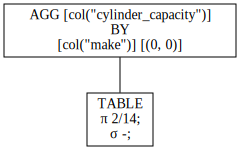

In [4] used 1.0 MiB RAM in 0.15s (system mean cpu 9%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 12989.2 MiB


In [4]:
dfple.lazy().groupby(by='make').agg('cylinder_capacity').show_graph()

In [5]:
%%time
result = dfple.filter(pl.col('cylinder_capacity').is_not_null()) \
.groupby(by='make').agg([pl.col('cylinder_capacity').count().alias('cyl_size'), pl.col('cylinder_capacity').median().alias('cyl_med')])\
.filter(pl.col('cyl_size') > 10).sort(by='cyl_med')
result[:3]

CPU times: user 33.8 s, sys: 31.1 s, total: 1min 4s
Wall time: 8.39 s


make,cyl_size,cyl_med
str,u32,f64
"""TESLA""",16,0.0
"""VECTRIX""",13,4.0
"""LINTEX HT50QT-…",12,49.0


In [5] used 3532.4 MiB RAM in 8.50s (system mean cpu 47%, single max cpu 100%), peaked 21794.6 MiB above final usage, current RAM usage now 16521.7 MiB


In [6]:
%%time
result = dfple.lazy().filter(pl.col('cylinder_capacity').is_not_null()) \
.groupby(by='make').agg([pl.col('cylinder_capacity').count().alias('cyl_size'), pl.col('cylinder_capacity').median().alias('cyl_med')])\
.filter(pl.col('cyl_size') > 10).sort(by='cyl_med').collect()
result[:3]

CPU times: user 17.8 s, sys: 5.38 s, total: 23.2 s
Wall time: 3.55 s


make,cyl_size,cyl_med
str,u32,f64
"""TESLA""",16,0.0
"""VECTRIX""",13,4.0
"""BEELINE""",304,49.0


In [6] used -2330.7 MiB RAM in 3.65s (system mean cpu 46%, single max cpu 100%), peaked 4837.7 MiB above final usage, current RAM usage now 14191.0 MiB


In [7]:
result.filter(pl.col('make') == 'ROLLS ROYCE')

make,cyl_size,cyl_med
str,u32,f64
"""ROLLS ROYCE""",11741,6749.0


In [7] used 0.0 MiB RAM in 0.11s (system mean cpu 8%, single max cpu 30%), peaked 0.0 MiB above final usage, current RAM usage now 14191.0 MiB


In [20]:
assert result.filter(pl.col('make') == 'ROLLS ROYCE')['cyl_med'].item() == 6749.0
assert result.filter(pl.col('make') == 'ROLLS ROYCE')['cyl_size'].item() == 11741.0

In [20] used 0.3 MiB RAM in 0.10s (system mean cpu 4%, single max cpu 9%), peaked 0.0 MiB above final usage, current RAM usage now 8336.8 MiB


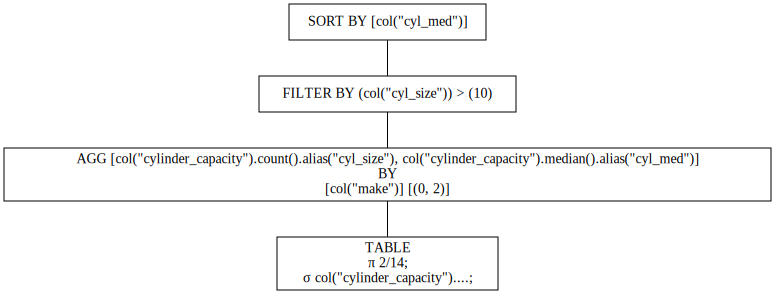

In [8] used 0.0 MiB RAM in 0.17s (system mean cpu 7%, single max cpu 38%), peaked 0.0 MiB above final usage, current RAM usage now 14191.0 MiB


In [8]:
dfple.lazy().filter(pl.col('cylinder_capacity').is_not_null()) \
.groupby(by='make').agg([pl.col('cylinder_capacity').count().alias('cyl_size'), pl.col('cylinder_capacity').median().alias('cyl_med')])\
.filter(pl.col('cyl_size') > 10).sort(by='cyl_med').show_graph()